In [37]:
import psutil
import subprocess
import time
import csv
from datetime import datetime
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np


### Function to check idle thresholds
def calculate_idle_thresholds(group):
    cpu_threshold = group['CPU_Usage'].quantile(0.2)
    gpu_threshold = group['GPU_Usage'].quantile(0.20)
    ram_threshold = group['RAM_Used'].quantile(0.20)
    return pd.Series({
        'cpu_threshold': cpu_threshold,
        'gpu_threshold': gpu_threshold,
        'ram_threshold': ram_threshold
    })




# Calculate thresholds for eac
### Import data
gaming = pd.read_csv(r'C:\Users\mohda\Documents\Python Scripts\gpu_logging\system_usage_log.csv')


###Drop NAs because I don't like them
gaming = gaming[~gaming.isna()]

### Handle datetime
gaming['Timestamp'] = pd.to_datetime(gaming['Timestamp'], format='%Y-%m-%d %H:%M:%S')

###Convert rams and bytes to GB, MB
bytes = ['RAM_Total','RAM_Available','RAM_Used', 'Bytes_Sent','Bytes_Received']
gaming[bytes]=gaming[bytes].apply(lambda x: x/1073741824)


### Costs 
costs = {'GPU':400, "CPU": 260, "RAM": 130, "SSD": 100}
ts_d = gaming.copy()
ts_d.set_index('Timestamp',inplace=True)
ts_d['hour'] = ts_d.index.hour


### Drop Nans
initial_row_count = len(ts_d)
ts_d.dropna(subset=['Top_GPU_Process', 'CPU_Usage', 'GPU_Usage', 'RAM_Used'], inplace=True)
final_row_count = len(ts_d)
rows_dropped = initial_row_count - final_row_count

print(f"Number of rows dropped: {rows_dropped}")

gaming.head()


Number of rows dropped: 45112


,Timestamp,CPU_Usage,Memory_Usage,RAM_Total,RAM_Available,RAM_Used,RAM_Percentage,Disk_Usage,GPU_Temperature,GPU_Usage,Bytes_Sent,Bytes_Received,Top_GPU_Process,GPU_Memory_Used_by_Top_Process
0,2024-08-17 20:25:10,7.8,68.0,31.218472,9.997833,21.220638,68.0,68.2,54.0,31.0,1.234836,30.311446,Cult Of The Lamb,[N/A]\r
1,2024-08-17 20:25:13,4.0,67.9,31.218472,10.017269,21.201202,67.9,68.2,54.0,40.0,1.234842,30.311454,Cult Of The Lamb,[N/A]\r
2,2024-08-17 20:25:17,5.6,67.8,31.218472,10.038788,21.179684,67.8,68.2,53.0,35.0,1.234854,30.311461,Cult Of The Lamb,[N/A]\r
3,2024-08-17 20:25:20,4.4,67.7,31.218472,10.069767,21.148705,67.7,68.2,53.0,35.0,1.234887,30.311508,Cult Of The Lamb,[N/A]\r
4,2024-08-17 20:25:23,13.7,68.6,31.218472,9.811050,21.407421,68.6,68.2,53.0,31.0,1.235013,30.311655,Cult Of The Lamb,[N/A]\r


In [41]:
##### We want to find idle states. Here I'll use Kmeans clustering

##Find the columns we're interested in.
usage_data = ts_d[['CPU_Usage', 'GPU_Usage', 'RAM_Used']]


kmeans = KMeans(n_clusters=2, random_state=0)
ts_d['state'] = kmeans.fit_predict(usage_data)

cluster_centers = kmeans.cluster_centers_
idle_cluster = np.argmin(np.sum(cluster_centers, axis=1))  
ts_d['is_idle'] = ts_d['state'] == idle_cluster

ts_d['time_diff'] = ts_d.index.to_series().diff().fillna(pd.Timedelta(seconds=0))
idle_df = ts_d[ts_d['is_idle']]
idle_time_by_task = idle_df.groupby('Top_GPU_Process')['time_diff'].sum()
print("\nIdle Time by Task:")
print(idle_time_by_task)




Idle Time by Task:
Top_GPU_Process
Cult Of The Lamb                   0 days 01:55:31
DSPGAME                            1 days 11:15:18
HELLCARD                           0 days 03:17:04
LOTF2                              0 days 01:16:03
LOTF2-WinGDK-Shipping              0 days 00:10:13
Lethal Company                     0 days 01:28:44
LikeaDragonIshin-WinGDK-Shipping   2 days 03:12:24
MonsterTrain                       2 days 10:00:06
Octopath_Traveler-Win64-Shipping   0 days 01:42:20
PlantsVsZombies                    0 days 16:07:34
Remnant2-WinGDK-Shipping           0 days 00:24:00
Risk of Rain 2                     1 days 01:00:39
Saltpeter-WinGDK-Shipping          1 days 01:58:46
bg3_dx11                           0 days 23:34:09
dota2                              0 days 02:06:59
Name: time_diff, dtype: timedelta64[ns]


In [29]:
### Detect idle state defined at the bottom 10%

thresholds = ts_d.groupby('Top_GPU_Process').apply(calculate_idle_thresholds)
print("Dynamic Idle Thresholds by Task:")
print(thresholds)



### Encode idle states
ts_d['is_idle'] = ts_d.apply(is_idle, axis=1, args=(thresholds,))

# Calculate time differences between timestamps
ts_d['time_diff'] = ts_d.index.to_series().diff().fillna(pd.Timedelta(seconds=0))

# Filter only idle states
idle_df = ts_d[ts_d['is_idle']]

# Calculate idle time per task
idle_time_by_task = idle_df.groupby('Top_GPU_Process')['time_diff'].sum()

print("\nIdle Time by Task:")
print(idle_time_by_task)

C:\Users\mohda\AppData\Local\Temp\ipykernel_440864\959305714.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  thresholds = ts_d.groupby('Top_GPU_Process').apply(calculate_idle_thresholds)


Dynamic Idle Thresholds by Task:
                                  cpu_threshold  gpu_threshold  ram_threshold
Top_GPU_Process                                                              
Cult Of The Lamb                           2.60           37.0      21.828712
DSPGAME                                    4.40           53.0      25.508947
HELLCARD                                   2.70           27.0      22.845312
LOTF2                                      6.00           24.0      23.091397
LOTF2-WinGDK-Shipping                      3.90           44.0      27.039551
Lethal Company                             3.14           35.0      24.541885
LikeaDragonIshin-WinGDK-Shipping           1.90           64.0      20.038330
MonsterTrain                               2.90           34.0      18.838739
Octopath_Traveler-Win64-Shipping           2.60           44.0      18.057237
PlantsVsZombies                            2.70            3.6      23.709763
Remnant2-WinGDK-Shipping       

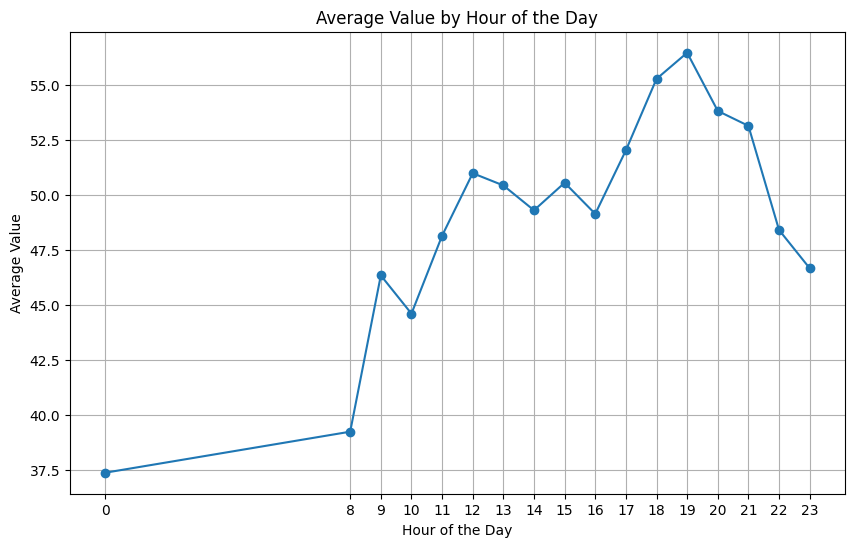

In [10]:
#Average usage 



def plot_hourly(val):
    ts_h = ts_d.groupby('hour')[val].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(ts_h.index, ts_h.values, marker='o')
    plt.title('Average Value by Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.xticks(ts_h.index)  # Set x-ticks to be each hour
    plt.show()

plot_hourly('GPU_Temperature')

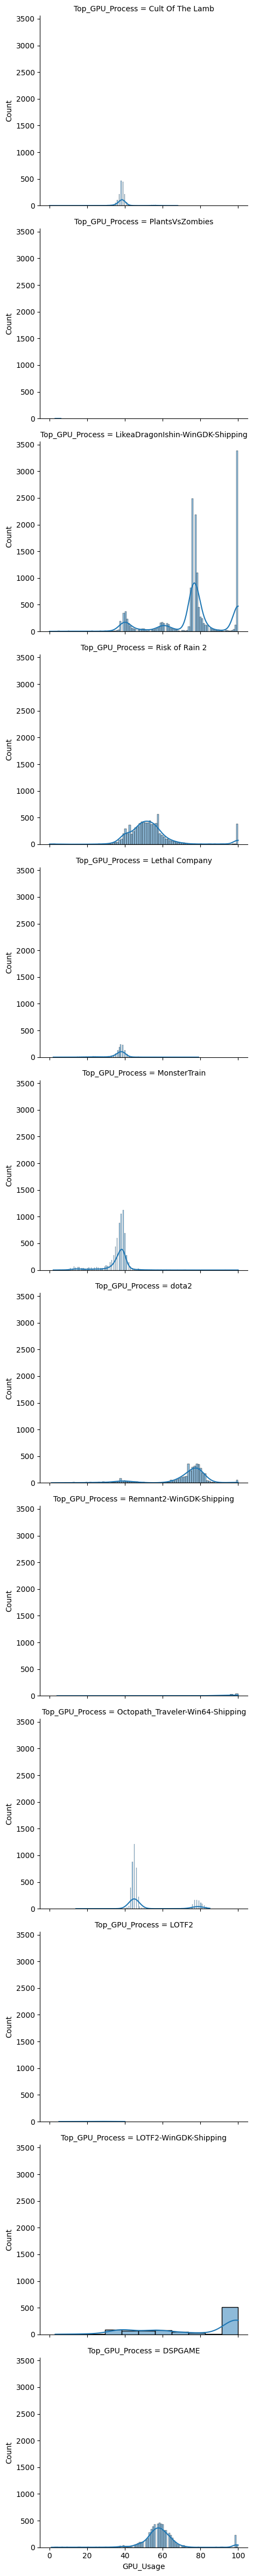

In [8]:
#### Plot 
g=sns.FacetGrid(gaming,row='Top_GPU_Process',height=4,aspect=1.2)
g.map(sns.histplot,'GPU_Usage',kde=True)